In [3]:
from pathlib import Path
import sys

ROOT = Path.cwd().resolve().parents[0]   # assumes notebook is run from notebooks/
sys.path.insert(0, str(ROOT))

import numpy as np
import pandas as pd



In [4]:
df = pd.read_csv(ROOT / "data" / "processed" / "xfoil_polars.csv")
print(df.shape)
display(df.head())

X = df[["alpha_deg", "Re", "Mach"]].to_numpy()
y = df[["CL", "CD"]].to_numpy()


(20, 7)


,alpha_deg,CL,CD,CM,Re,Mach,airfoil
0,-5.0,-0.3139,0.00862,-0.0582,1000000.0,0.2,NACA 2412
1,-4.0,-0.2024,0.00786,-0.0569,1000000.0,0.2,NACA 2412
2,-3.0,-0.0903,0.00721,-0.0559,1000000.0,0.2,NACA 2412
3,-2.0,0.0220,0.00671,-0.0551,1000000.0,0.2,NACA 2412
4,-1.0,0.1331,0.00623,-0.0543,1000000.0,0.2,NACA 2412


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    "linear": Pipeline([
        ("scaler", StandardScaler()),
        ("reg", LinearRegression())
    ]),
    "poly2_ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("reg", Ridge(alpha=1.0))
    ]),
    "rf": MultiOutputRegressor(
        RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
    )
}

def evaluate(name, model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred, multioutput="raw_values")
    rmse = np.sqrt(mean_squared_error(y_test, pred, multioutput="raw_values"))
    r2 = r2_score(y_test, pred, multioutput="raw_values")

    print(f"\n{name}")
    print("  MAE  (CL, CD): ", mae)
    print("  RMSE (CL, CD): ", rmse)
    print("  R2   (CL, CD): ", r2)

for name, model in models.items():
    evaluate(name, model)



linear
  MAE  (CL, CD):  [0.08433017 0.00693405]
  RMSE (CL, CD):  [0.09329255 0.00849065]
  R2   (CL, CD):  [ 0.98741833 -0.13099953]

poly2_ridge
  MAE  (CL, CD):  [0.04299118 0.00351281]
  RMSE (CL, CD):  [0.04955398 0.00360211]
  R2   (CL, CD):  [0.99645022 0.79643914]

rf
  MAE  (CL, CD):  [0.13368244 0.00103186]
  RMSE (CL, CD):  [0.16913164 0.00111848]
  R2   (CL, CD):  [0.95864822 0.98037367]


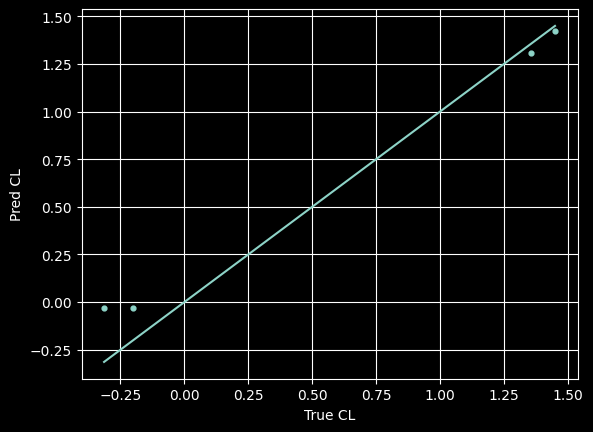

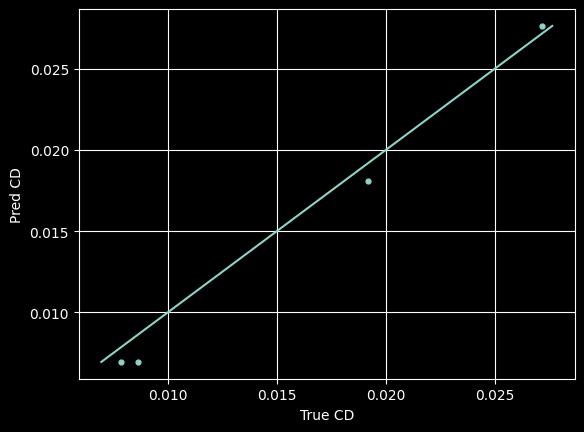

In [6]:
import matplotlib.pyplot as plt

best = models["rf"]
best.fit(X_train, y_train)
pred = best.predict(X_test)

# CL
plt.figure()
plt.scatter(y_test[:,0], pred[:,0], s=12)
mn, mx = min(y_test[:,0].min(), pred[:,0].min()), max(y_test[:,0].max(), pred[:,0].max())
plt.plot([mn, mx], [mn, mx])
plt.xlabel("True CL")
plt.ylabel("Pred CL")
plt.grid(True)
plt.show()

# CD
plt.figure()
plt.scatter(y_test[:,1], pred[:,1], s=12)
mn, mx = min(y_test[:,1].min(), pred[:,1].min()), max(y_test[:,1].max(), pred[:,1].max())
plt.plot([mn, mx], [mn, mx])
plt.xlabel("True CD")
plt.ylabel("Pred CD")
plt.grid(True)
plt.show()
